# Primitive fitting

As seen in previous notebooks, a pointcloud is a kind of 3D representation obtained by (physically or virtually) sampling the surfaces of one of several objects. Here, these surfaces are represented by a set of points (discrete representation). While quite easy to store and manipulate, pointclouds are not really optimal in terms of compactness and ease of manipulation. Indeed, parametric 3D shapes are often preferred for complex 3D data thanks to their ability to provide an "exact" (i.e., continuous) representation of surfaces with only a few parameters, making most "high-level" operations (e.g., computing intersections) easier.

This is why, in many applications (path finding in robotics, object placement in augmented reality, reverse engineering, etc.), the pointcloud or a subset of it is being replaced by parametric surfaces. This process is called *abstraction* as **"low-level" points are replaced by "higher-level" geometric entities**.

Among parametric surfaces, geometric primitives are often considered first. **Geometric primitives are basic surfaces such as: plane, sphere, cylinder, cone, and torus**. Indeed, these kinds of surfaces are very often found in manufactured objects and sometimes in natural scenes.

The challenge here is then to fit or adjust geometric primitives to subsets of the pointcloud (that is assumed to have already been segmented).

The next sections cover the notions of parameters and distance for each kind of geometric primitive and some of the best algorithms for solving our fitting problem.

## Introductory notions and considerations

Just as in the case of fitting a model to data, fitting a primitive to a set of points comes down to minimizing a measure of "goodness of fit", that is a certain quantity materializing the deviation between the surface and the data. As often, the fitting is here considered in the sense of least squares.

Considering this, the problem to be solved can be formulated as follows:

*Given a set $P$ of $n$ points sampling a surface $S$ of known nature but unknown parameters $\theta$, find the optimal set of parameters $\theta_{opt}$ that minimizes the sum of the squared distances between the surface and the points:*
\begin{equation*}
res(\theta) = \sum^{n-1}_{i=0} d(p_{i}, S(\theta))^{2}
\end{equation*}

The sum of the squared distances is also called the residual.

Note that, to be completely rigorous, the above equation considers that the measurement noise affecting the points has the same intensity for each point. Alternatively, an estimate of the standard deviation $\sigma_i$ of the noise may be used to "weight" the contribution of each point.

For the rest of this notebook and for the sake of simplicity, the term of error function (noted $E$) is used and the distance function (noted $f$) is expressed only with respect to its parameters, giving simply:
\begin{equation*}
E(\theta) = \sum^{n-1}_{i=0} f(\theta)^{2}
\end{equation*}

Note also that the formulation of the distance function $f$ has a direct impact on the optimization process. In this regard, it is generally a good idea to try to reduce the number of parameters (or the length of the parameters vector $\theta$) to a minimum.

One common "trick" is to express unit vectors using spherical coordinates instead of Cartesian coordinates, allowing them to be described with only two coordinates (instead of three coordinates and a constraint). For example, a unit normal vector may be written $n = [n_x, n_y, n_z]$ using Cartesian coordinates, but also $n = [\rho, \theta, \phi]$ using spherical coordinates. Remembering that $||n|| = 1$ it is possible to deduce that $\rho = 1$ and omit this coordinate.


In [1]:
# Necessary imports
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

sys.path.append("./utils")
from manip_utils import rotation_f_to_t
from maths_utils import cartesian_to_spherical, spherical_to_cartesian

## Plane

### Plane parameters

There are in practice several manners to describe a planar surface. The most common one consists in using its Cartesian equation $a.x + b.y + c.z + d = 0$, with the parameters $a$, $b$ and $c$ describing its orientation and the parameter $d$ its distance to the origin. Another one consists in using its normal $n = [a, b, c]$ and any given point $p$ belonging to the plane and thus verifying $p \cdot n = -d$. Note that these first two examples describe an infinite or unbounded plane. 

It is however possible to integrate the notion of limits without adding too much complexity by considering a rectangular plane. In this case, $p$ is replaced by the center of the plane noted $c$. A unit vector $t$, orthogonal to $n$, is introduced to describe the length direction of the plane (the width direction is given by $b = n \times t$). The scalars $l$ and $w$ describe the length and the width of the plane.

| Parameter | Description |
|:----------|:------------|
| $c$       | center of the plane |
| $n$       | unit normal vector |
| $t$       | unit vector giving the length direction |
| $l$       | length |
| $w$       | width |

 

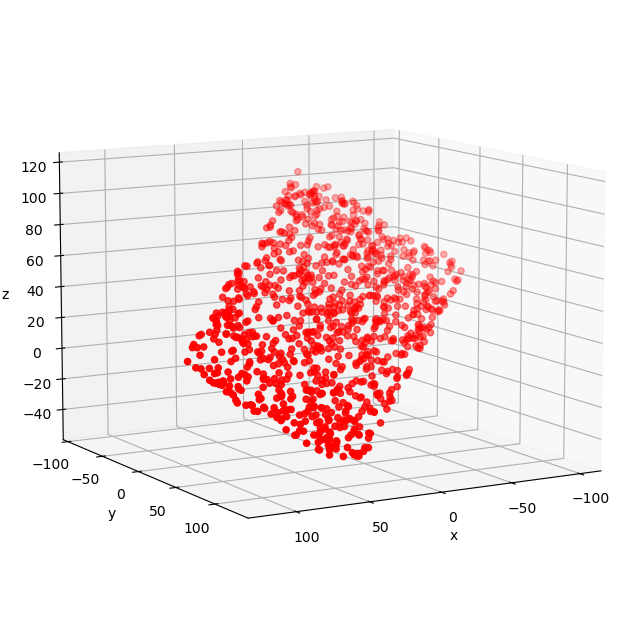

In [2]:
def generate_plane(center, normal, tangent, length, width, n=1000):

    # Start with a unit plane pointing towards z
    x = np.random.uniform(-.5, .5, n)
    y = np.random.uniform(-.5, .5, n)
    z = np.zeros(n)
    points = np.stack((x, y, z), axis=1)
    # Adjust dimensions
    points[:, 0] *= length
    points[:, 1] *= width
    # Adjust orientation
    R = np.stack((tangent, np.cross(normal, tangent), normal), axis=1)
    points = (R @ points.T).T
    # Adjust position
    return points + center


# Create a plane pointcloud
plane_center = np.array([10., 20., 30.])
plane_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.]) # z-y-x rotation of (np.pi/4, 0., np.pi/4)
plane_tangent = np.array([np.sqrt(2)/2., 0.5, -0.5])
plane_length = 200.
plane_width = 125.
points_plane = generate_plane(plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_plane[:, 0], points_plane[:, 1], points_plane[:, 2],
           c="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()



### Point-to-plane distance

The distance between a point $p$ and a rectangular plane $P$ is given by:
\begin{equation*}
d(p, P) = \sqrt{d_{n}^2 + \max(0, |d_{t}| - l/2)^2 + \max(0, |d_{b}| - w/2)^2}
\end{equation*}
with:
\begin{equation*}
d_{n} = n \cdot (p - c) \quad d_{t} = t \cdot (p - c) \quad d_{b} = (t \times n) \cdot (p - c)
\end{equation*}

The two later terms can be neglected in the case of an infinite plane.

Note that, in this definition, the distance is unsigned. It is often useful to sign the distance to add the notion of "which side" of the surface the point is located. Here the positive side corresponds to the one in which the normal $n$ is pointing:
\begin{equation*}
d(p, P) = \text{sign}(d_{n}) . \sqrt{d_{n}^2 + \max(0, |d_{t}| - l/2)^2 + \max(0, |d_{b}| - w/2)^2}
\end{equation*}


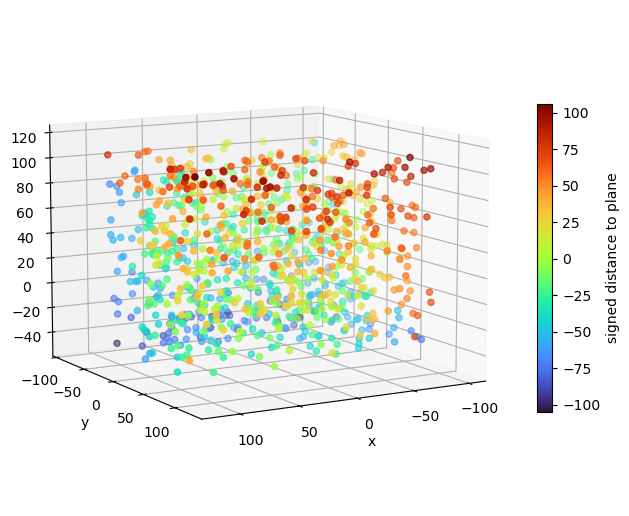

In [3]:
def dist_to_plane(points, center, normal, tangent=None, length=None, width=None):
    """Signed distance to the plane."""

    # Distance along the normal direction
    vec_to_center = points - center
    d_z = vec_to_center @ normal
    if tangent is None:
        return d_z
    # distance along the other dimensions (might be a finite or semi-infinite plane)
    d_x = vec_to_center @ tangent if length is not None else 0.
    d_y = vec_to_center @ np.cross(normal, tangent) if width is not None else 0.
    # Total distance
    d_xyz = np.sqrt(d_z**2 + (np.abs(d_x) - length/2).clip(0)**2 + (np.abs(d_y) - width/2).clip(0)**2)
    # Signed distance
    return np.sign(d_z) * d_xyz


# Generate a set of random points and compute distances to the plane
random_points = np.random.uniform(points_plane.min(axis=0), points_plane.max(axis=0), (1000, 3))
dists_plane = dist_to_plane(random_points, plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_plane, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to plane')
plt.axis("equal")
plt.show()
    

### Least squares plane

There are also several manners to compute the "best fit" plane in the sense of least squares.

#### Using minimization techniques

One approach consists in using the Cartesian equation of the plane and derive the following distance function $f$:
\begin{equation*}
f(n, d) = p \cdot n + d
\end{equation*}
(here the normal vector $n$ is assumed to be a unit vector).

The error function to be minimized is then written:
\begin{equation*}
E(n, d) = \sum^{n-1}_{i=0} f(n, d)^{2}
\end{equation*}

It involves 3 parameters: one for $d$, and two for $n$ (unit vector expressed with spherical coordinates).

The optimal parameters, minimizing the error function, may then be estimated using classic minimization techniques for nonlinear least squares, such as the Levenberg-Marquardt algorithm.

#### Direct approach

Thankfully, there is a direct method to find the optimal parameters for a plane. It only involves a *Principal Component Analysis* (or PCA) of the vectors containing the coordinates of the points.

First, the inertia matrix of the pointcloud is computed:
\begin{equation*}
I_n = \sum^{n-1}_{i=0} (p_i - \bar{p}) \cdot (p_i - \bar{p})^{T}
\end{equation*}

with $\bar{p}$ being the center of mass of the pointcloud:
\begin{equation*}
\bar{p} = \sum^{n-1}_{i=0} p_i
\end{equation*}

The eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ (with $\lambda_1 \geq \lambda_2 \geq \lambda_3$) and eigenvectors $\nu_1$, $\nu_2$ and $\nu_3$ are then computed from $I_n$. The obtained eigenvectors define an orthonormal frame such as:
\begin{equation*}
n = \nu_3 \quad \text{and} \quad t = \nu_1
\end{equation*}

Note that $\lambda_3$ is equal to the residual.

A change of reference (back and forth) from the centered pointcloud to that of principal components allow to compute $c$, $l$, and $w$.

Note that the computed plane is guaranteed to include the points but **its area is not minimal**.


Fitted plane center is: [ 9.643 20.393 29.607] , normals is: [-0.     0.707  0.707] , tangent is: [-0.684 -0.516  0.516] , length is: 200.841 , width is: 128.382
Fitted plane residual is: 2.391653377457316e-10


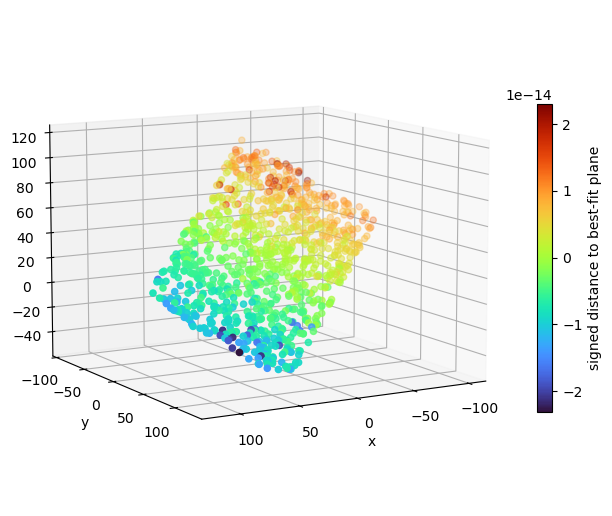

In [4]:
def fit_plane(points):

    # Center pointcloud
    centroid = points.mean(axis=0)
    X = points - centroid
    # Covariance matrix
    cov = X.T @ X
    # Eigen decomposition (eigenvalues in ascending order)
    w, v = np.linalg.eigh(cov)
    # Sum of squared residuals is equal to the smallest eingen value
    res = w[0]
    # Nomal vector
    normal = v[:, 0]
    # Tangent vector (length direction)
    tangent = v[:, 2]
    # Projection into eigen vectors basis (u=normal, v=width, w=length)
    Y = (v.T @ X.T).T
    # Length and width are the largest dimensions of the bounding box
    _, width, length = Y.ptp(axis=0)
    bbox_center = (Y.max(axis=0) + Y.min(axis=0))/2
    # Center of the plane is the center of the bounding plane (v, w directions)
    shift = np.array([0., bbox_center[1], bbox_center[2]])
    center = centroid + v @ shift

    return (center, normal, tangent, length, width), res


# Fit plane to pointcloud
parameters_best_fit_plane, res_best_fit_plane = fit_plane(points_plane)
best_fit_plane_center, best_fit_plane_normal, best_fit_plane_tangent, best_fit_plane_length, best_fit_plane_width = parameters_best_fit_plane

with np.printoptions(precision=3, suppress=True):
    print("Fitted plane center is:", best_fit_plane_center,
          ", normals is:", best_fit_plane_normal, 
          ", tangent is:", best_fit_plane_tangent,
          ", length is: {:.3f}".format( best_fit_plane_length),
          ", width is: {:.3f}".format(best_fit_plane_width))
print("Fitted plane residual is:", res_best_fit_plane)

# Show distance to best-fit
dists_best_fit_plane = dist_to_plane(
    points_plane,
    best_fit_plane_center,
    best_fit_plane_normal,
    best_fit_plane_tangent,
    best_fit_plane_length,
    best_fit_plane_width
)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points_plane[:, 0], points_plane[:, 1], points_plane[:, 2],
          c=dists_best_fit_plane, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to best-fit plane')
plt.axis("equal")
plt.show()



## Sphere

### Sphere parameters

One straightforward manner to define a sphere is by using its Cartesian equation $(x - c_x)^2 + (y - c_y)^2 + (z - c_z)^2 = r^2$, where $[c_x, c_y, c_z]$ are the coordinates of its center $c$ and $r$ its radius.

| Parameter | Description |
|:----------|:------------|
| $c$       | center |
| $r$       | radius |


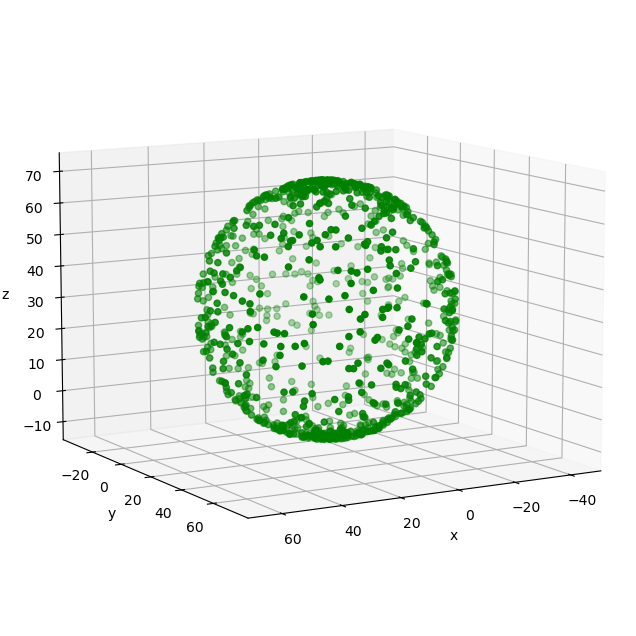

In [5]:
def generate_sphere(center, radius, n=1000):

    # Start with a unit sphere
    theta = np.random.uniform(0., np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    points = np.hstack((x, y, z))
    # Adjust radius
    points *= radius
    # Adjust position
    return points + center


# Create a sphere pointcloud
sphere_center = np.array([10., 20., 30.])
sphere_radius = 40.
points_sphere = generate_sphere(sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
           c="green",)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


### Point-to-sphere distance

The signed distance between a point $p$ and a sphere $S$ is simply given by:
\begin{equation*}
d(p, S) = || p - c || - r
\end{equation*}

Here the positive side corresponds to the "exterior" of the sphere.


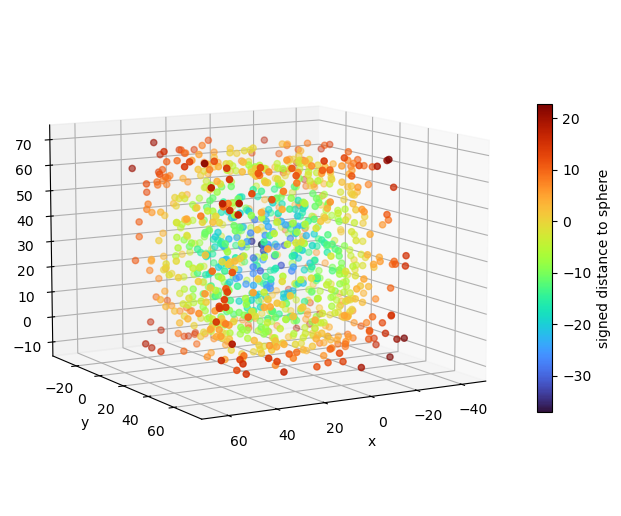

In [6]:
def dist_to_sphere(points, center, radius):
    """Signed distance to the sphere."""

    return np.linalg.norm(points - center, axis=1) - radius


# Generate a set of random points and compute distances to the sphere
random_points = np.random.uniform(points_sphere.min(axis=0), points_sphere.max(axis=0), (1000, 3))
dists_sphere = dist_to_sphere(random_points, sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_sphere, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to sphere')
plt.axis("equal")
plt.show()


### Least squares sphere

There are also several manners to compute the "best fit" sphere in the sense of least squares.

#### Using minimization techniques

One approach consists in using the Cartesian equation of the sphere and derive the following distance function $f$:
\begin{equation*}
f(c, r) = || p - c || - r
\end{equation*}

The error function to be minimized is then written:
\begin{equation*}
E(c, r) = \sum^{n-1}_{i=0} f(c, r)^{2}
\end{equation*}

It involves 4 parameters: three for $c$, and one for $r$.

The optimal parameters, minimizing the error function, may then be estimated using classic minimization techniques for nonlinear least squares, such as the Levenberg-Marquardt algorithm.

#### Direct approach

Just like in the case of the plane, there is a direct method to find the optimal parameters of a sphere.

Remembering its Cartesian equation:
\begin{equation*}
(x - c_x)^2 + (y - c_y)^2 + (z - c_z)^2 = r^2
\end{equation*}

it is possible to develop it and rearrange its terms into:
\begin{equation*}
2.x.c_x + 2.y.c_y + 2.z.c_z + r^2 - c_{x}^{2} - c_{y}^{2} - c_{z}^{2} = x^{2} + y^{2} + z^{2}
\end{equation*}

The left part now includes the sphere parameters, and the right part is simply the sum of the squared coordinates of the points.

Setting $t = r^2 - c_{x}^{2} - c_{y}^{2} - c_{z}^{2}$ allows to write the fitting problem as a linear least squares problem $Ax = b$ with $x = [c_{x}, c_{y}, c_{z}, t]$.

It can then be resolved by a linear least squares resolution algorithm.


Fitted sphere center is: [10. 20. 30.] , radius is: 40.000
Fitted sphere residual is [3.98225063e-22]


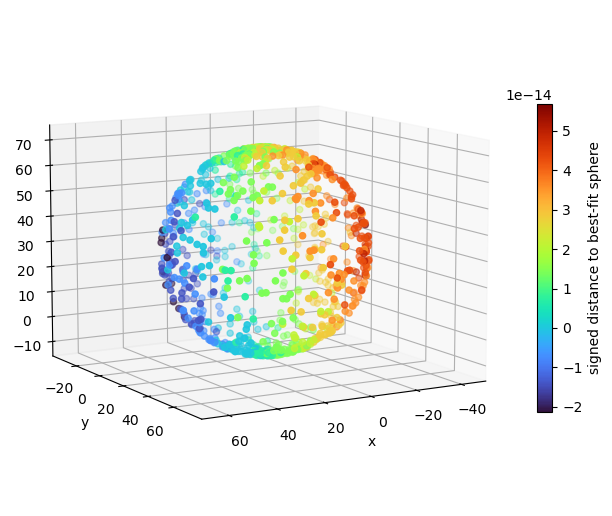

In [7]:
def fit_sphere(points):

    # Coefficient matrix and values
    A = np.column_stack((2*points, np.ones(len(points))))
    b = (points**2).sum(axis=1)
    # Solve A x = b
    x, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # Sphere parameters
    center = x[:3]
    radius = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2 + x[3])
   
    return (center, radius), res


# Fit sphere to pointcloud
best_fit_sphere_parameters, best_fit_sphere_res = fit_sphere(points_sphere)
best_fit_sphere_center, best_fit_sphere_radius = best_fit_sphere_parameters

with np.printoptions(precision=3, suppress=True):
    print("Fitted sphere center is:", best_fit_sphere_center,
          ", radius is: {:.3f}".format(best_fit_sphere_radius))
print("Fitted sphere residual is", best_fit_sphere_res)


# Show distance to best-fit
dists_best_fit_sphere = dist_to_sphere(points_sphere, best_fit_sphere_center, best_fit_sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
          c=dists_best_fit_sphere, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to best-fit sphere')
plt.axis("equal")
plt.show()


## Cylinder

### Cylinder parameters

It is possible to define an infinite cylinder whose axis points to z by its Cartesian equation $(x - c_x)^2 + (y - c_y)^2 = r^2$ where $[c_x, c_y, c_z]$ are the coordinates of its center $c$ and $r$ its radius. However, this configuration is quite limited.

We consider here a cylinder of any orientation that is truncated by two planes perpendicular to its axis. The point $c$, situated on the axis of the cylinder and equidistant from the planes that bound it, refers to its center. The unit vector $n$ designates the direction of the cylinder axis. The scalars $r$ and $l$ describe the radius and the length of the cylinder.

| Parameter | Description |
|:----------|:------------|
| $c$       | center |
| $n$       | unit vector giving the direction of the axis |
| $r$       | radius |
| $l$       | length |


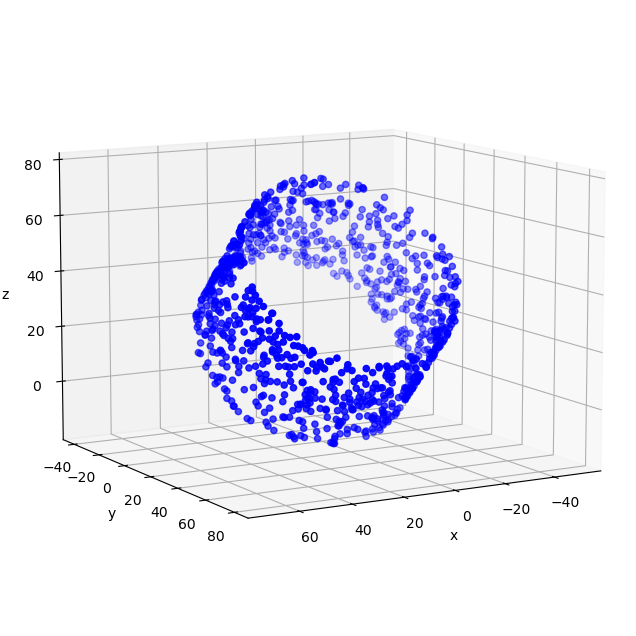

In [8]:
def generate_cylinder(center, normal, radius, length, n=1000):

    # Start with a unit cylinder pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.cos(theta)
    y = np.sin(theta)
    z = np.random.uniform(-0.5, 0.5, (n, 1))
    points = np.hstack((x, y, z))
    # Adjust radius and length
    points[:, :2] *= radius
    points[:, 2] *= length
    # Adjust orientation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust center
    return points + center


# Create a cylinder pointcloud
cylinder_center = np.array([10., 20, 30.])
cylinder_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cylinder_radius = 40.
cylinder_length = 50.
points_cylinder = generate_cylinder(cylinder_center, cylinder_normal, cylinder_radius, cylinder_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cylinder[:, 0], points_cylinder[:, 1], points_cylinder[:, 2],
           c="blue")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

### Points-to-cylinder distance

The signed distance between a point $p$ and a cylinder $C$ is simply given by:
\begin{equation*}
d_r(p, C) = || n \times (p - c) || - r
\end{equation*}
the first term being the distance between $p$ and the axis.

Here the positive side corresponds to the "exterior" of the cylinder.

In the case that the cylinder is truncated by two planes perpendicular to its axis, it is necessary to consider the distance between the points and the two circles $C_1$ and $C_2$ resulting from the intersection between the cylinder and the planes.

The projected distance between the center of the cylinder and the points on the cylinder axis is given by:
\begin{equation*}
d_z(p, C) = n \cdot (p - c)
\end{equation*}

Points verifying:
\begin{equation*}
d_z(p, C) > l/2 \quad \text{or} \quad d_z(p, C) < - l/2 \quad
\end{equation*}
are "outside" the cylinder in its axis-direction.

Their distance to the cylinder is equal to their distance to the bounding circles:
\begin{equation*}
d(p, C_i) = \sqrt{[n \cdot (p - c_i)]^2 + (|| n \times (p - c_i) || - r)^2}
\end{equation*}

with $c_1$ and $c_2$ being the center of the two circles $C_1$ and $C_2$ with coordinates $c_1 = c - l/2$ and $c_2 = c + l/2$.

For the other points, just consider:
\begin{equation*}
d(p, C) = d_r(p, C)
\end{equation*}


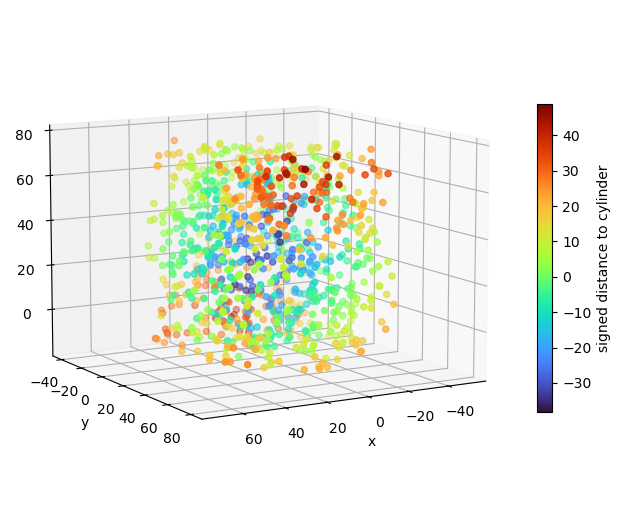

In [9]:
def dist_to_cylinder(points, center, normal, radius, length=None):
    """Signed distance to the cylinder"""

    # Distance to axis
    vec_to_center = points - center
    dist_to_axis = np.linalg.norm(np.cross(normal, vec_to_center), axis=1)
    # Distance to lateral surface
    d_r = dist_to_axis - radius
    if length is None:
        return d_r
    
    # If our cylinder is bounded (by two plane perpendicular to the axis)
    # there 3 cases to consider:
    d_t = np.zeros(len(d_r), dtype=float)
    # Projection on axis
    d_z = vec_to_center @ normal
    
    # 1. points that are "inside" the cylinder on z direction
    # (distance to lateral surface)
    inds_in = np.nonzero(np.abs(d_z) <= length/2)[0]
    d_t[inds_in] = d_r[inds_in]
    
    # 2. points that are "outside" the cylinder on -z direction
    inds_out_1 = np.nonzero(d_z < -length/2)[0]
    # Distance to end-circle
    c_1 = center - length/2 * normal
    vec_to_c_1 = points[inds_out_1] - c_1
    dist_to_axis_1 = np.linalg.norm(np.cross(normal, vec_to_c_1), axis=1)
    dist_to_circle_1 = np.sqrt((vec_to_c_1 @ normal)**2 + (dist_to_axis_1 - radius)**2)
    d_t[inds_out_1] = dist_to_circle_1
    
    # 3. Points "outside" the cylinder on +z direction
    inds_out_2 = np.nonzero(d_z > length/2)[0]
    # Distance to end-circle
    c_2 = center + length/2 * normal
    vec_to_c_2 = points[inds_out_2] - c_2
    dist_to_axis_2 = np.linalg.norm(np.cross(normal, vec_to_c_2), axis=1)
    dist_to_circle_2 = np.sqrt((vec_to_c_2 @ normal)**2 + (dist_to_axis_2 - radius)**2)
    d_t[inds_out_2] = dist_to_circle_2
    
    return d_t


# Generate a set of random points and compute distances to the cylinder
random_points = np.random.uniform(points_cylinder.min(axis=0), points_cylinder.max(axis=0), (1000, 3))
dists_cylinder = dist_to_cylinder(random_points, cylinder_center, cylinder_normal, cylinder_radius, cylinder_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_cylinder, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to cylinder')
plt.axis("equal")
plt.show()


### Least-squares cylinder

There is unfortunately no direct method to find the optimal parameters of a cylinder and resources documenting this problem are quite scarce.

The solution described here is found in: Eberly, D. (1999). Least Squares Fitting of Data by Linear or Quadratic Structures. *Technical report, Geometric Tools*. https://www.geometrictools.com/.

Starting from the Cartesian equation of the cylinder:
\begin{equation*}
x^{2} + y^{2} = r^{2}
\end{equation*}

Let $u$ and $v$ be unit vectors such as $\{u, v, n\}$ ($n$ being the unit vector giving the direction of the axis) an orthonormal basis. A given point $p$ is written:
\begin{equation*}
p = c + q_0.u + q_1.v + q_2.n = c + R \cdot q
\end{equation*}
where $R$ is a rotation matrix whose columns are $u$, $v$, and $n$ and where $q$ is a column vector whose rows are $q_0 = u \cdot (p - c)$, $q_1 = v \cdot (p - c)$ and $q_2 = n \cdot (p - c)$.

For $p$ to be on the cylinder it is necessary that:
\begin{equation*}
\begin{aligned}
r^2 & = q_{0}^{2} + q_{1}^{2} \\
 & = [u \cdot (p - c)]^2 + [v \cdot (p - c)]^2 \\
 & = (p - c)^T (uu^T + vv^T)(p - c) \\
 & = (p - c)^T (I - nn^T)(p - c) \\
\end{aligned}
\end{equation*}

The following distance function $f$ is obtained:
\begin{equation*}
f(c, n, r^2) = (p - c)^T (I - nn^T)(p - c) - r^{2}
\end{equation*}

The error function to be minimized is then written:
\begin{equation*}
E(c, n, r^{2}) = \sum^{n-1}_{i=0} f(c, n, r^{2})^{2}
\end{equation*}

It involves six parameters: one for $r^2$, three for $c$, and two for $n$ (unit vector expressed with spherical coordinates).

The optimal parameters, minimizing the error function, may be estimated using minimization techniques for nonlinear least squares, such as the Levenberg-Marquardt algorithm. Note that its convergence depends on a "good" initial guess of the parameters.

Another option, described in the cited report, consists in calculating the partial derivatives of the error function, the global minimum being reached when these are zero. Unfortunately the equation for the normal is not easily resolved, but an approximation may be computed minimizing a function $G$ whose details are given in the report. A technique is also given to speed-up the computation of $G$.

The second method (without the "acceleration technique") is implemented below.


Fitted cylinder center is: [10.    19.685 29.685] , normal is: [-0.     0.707  0.707] , radius is: 41.816
Fitted cylinder residual is 2.938405497135861e-22


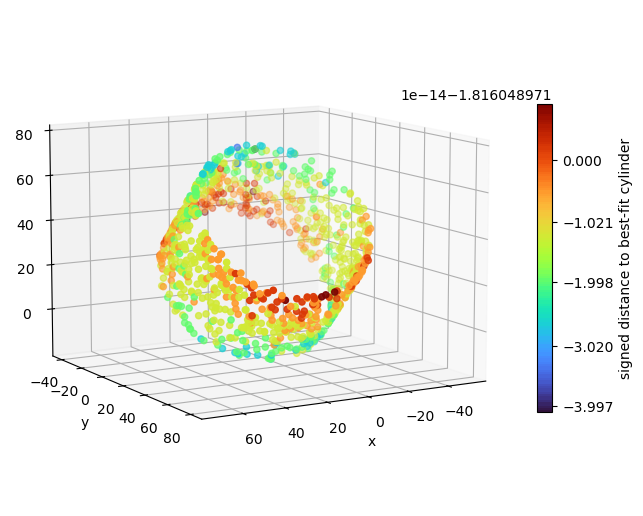

In [10]:
def fit_cylinder(points, normal_initial_guess=[0., 0., 1.]):

    # Convert 
    start_point = cartesian_to_spherical(normal_initial_guess)
    
    # Center the pointcloud around its centroid 
    centroid = points.mean(axis=0)
    centered_points = points - centroid
    
    # Normal is obtained through the minimization of a function G
    best_fit = minimize(
        lambda x : G(spherical_to_cartesian(x), centered_points),
        start_point,
        method='Powell', # works well with noisy measurements
    )
    normal = spherical_to_cartesian(best_fit.x)
    res = best_fit.fun

    # The others parameters are directly retrieved once the normal is computed
    
    # Projection matrix P
    P = np.eye(3) - normal.reshape(-1, 1) @ normal.reshape(1, -1)
    # Projected points
    projected_points = (P @ centered_points.T).T
    # Inertia matrix
    A = projected_points.T @ projected_points
    # Skew symmetric matrix
    S = np.array([[0, -normal[2], normal[1]], [normal[2], 0, -normal[0]], [-normal[1], normal[0], 0]])
    # Adjugate of the matrix representing A
    A_hat = S @ (A @ S.T)
    
    # Center
    center = (A_hat/np.trace(A_hat @ A)) @ ((projected_points * projected_points).sum(axis=1).reshape(-1, 1) * projected_points).sum(axis=0)
    center += centroid
    
    # Radius
    r2 = sum(np.dot(center - points, np.dot(P, center - points)) for points in centered_points) / len(centered_points)
    radius = np.sqrt(r2)    
    
    # Length
    length = np.ptp((points - center) @ normal)
    
    return (center, normal, radius, length), res


def G(normal, centered_points):
    """Error function for the direction/normal of the cylinder"""
    
    # Projection matrix P
    P = np.eye(3) - normal.reshape(3, 1) @ normal.reshape(1, 3)
    # Projected points
    projected_points = (P @ centered_points.T).T
    # Inertia matrix
    A = projected_points.T @ projected_points
    # Skew symmetric matrix
    S = np.array([[0, -normal[2], normal[1]], [normal[2], 0, -normal[0]], [-normal[1], normal[0], 0]])
    # Adjugate of the 2 × 2 matrix representing A
    A_hat = S @ (A @ S.T)
    # Intermediate terms for the G function
    s = (projected_points**2).sum(axis=1).reshape(-1, 1)
    u = s.sum()/len(centered_points)
    v = (A_hat / np.trace(A_hat @ A)) @ (s * projected_points).sum(axis=0)
    
    return ((s - u - 2*(projected_points @ v).reshape(-1, 1))**2).sum()


# Fit cylinder to pointcloud
best_fit_cylinder_parameters, best_fit_cylinder_res = fit_cylinder(points_cylinder)
best_fit_cylinder_center, best_fit_cylinder_normal, best_fit_cylinder_radius, best_fit_cylinder_length = best_fit_cylinder_parameters

with np.printoptions(precision=3, suppress=True):
    print("Fitted cylinder center is:", best_fit_cylinder_center,
          ", normal is:", best_fit_cylinder_normal,
          ", radius is: {:.3f}".format(best_fit_cylinder_radius))
print("Fitted cylinder residual is", best_fit_cylinder_res)

# Show distance to best-fit
dists_best_fit_cylinder = dist_to_cylinder(points_cylinder, best_fit_cylinder_center, best_fit_cylinder_normal, best_fit_cylinder_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points_cylinder[:, 0], points_cylinder[:, 1], points_cylinder[:, 2],
          c=dists_best_fit_cylinder, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to best-fit cylinder')
plt.axis("equal")
plt.show()



## Cone

### Cone parameters

It is possible to define an infinite cone whose axis points to z by its Cartesian equation $(x - c_x)^2 + (y - c_y)^2 = (z - c_z)^2.\tan^2 \alpha$ where $[c_x, c_y, c_z]$ are the coordinates of its apex $c$ and $\alpha$ its half angle. This cone is "double-sided", i.e. the surface of the cone extends on either side of its apex, making it look like a hourglass. This configuration is, again, quite limited.

We consider here a "single-sided" cone of any orientation that is limited by its apex and truncated by a plane perpendicular to its axis. The unit vector $n$ designates the direction of the cone axis from its base to its apex. The scalars $\alpha$ and $l$ describe the half-angle and the length of the cone.

| Parameter | Description |
|:----------|:------------|
| $c$       | apex position |
| $n$       | unit vector giving the direction of the axis |
| $\alpha$  | half-angle |
| $l$       | length |


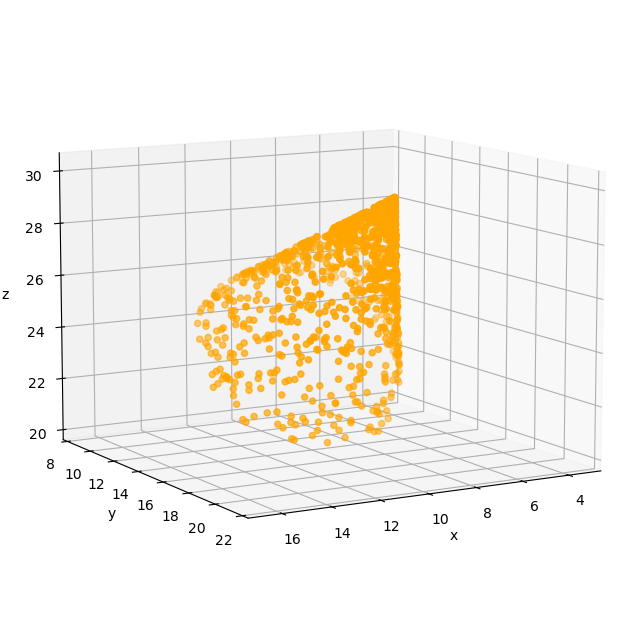

In [11]:
def generate_cone(apex, normal, half_angle, length, n=1000):
    """base radius of 1."""

    # Start with a cone of custom size pointing towards -z
    z = np.random.uniform(-length, 0., (n, 1))
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = z * np.tan(half_angle) * np.cos(theta)
    y = z * np.tan(half_angle) * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust rotation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust position (apex)
    return points + apex

# Generate a cone pointcloud
cone_apex = np.array([10., 20., 30.])
cone_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cone_half_angle = np.pi/8
cone_length = 10.
points_cone = generate_cone(cone_apex, cone_normal, cone_half_angle, cone_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cone[:, 0], points_cone[:, 1], points_cone[:, 2],
           c="orange")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


### Point-to-cone distance

The signed distance between a point $p$ and a cone $C$ is simply given by:
\begin{equation*}
d_r(p, C) = (|| n \times (p - c) || - |p \cdot n|.\tan\alpha).\cos\alpha
\end{equation*}
the first term being the distance between $p$ and the axis and the second the radius of the circle resulting from the intersection with the plane defined by $(p, n)$.

Here the positive side corresponds to the "exterior" of the cone.

In the case that the cone is limited by its apex and a plane perpendicular to its axis, it is necessary to consider the distance between the points and the apex and the circle $C_1$ resulting from the intersection between the cone and the plane.

The projected distance between the apex of the cylinder and the points on the cone axis is given by:
\begin{equation*}
d_z(p, C) = n \cdot (p - c)
\end{equation*}

Points verifying:
\begin{equation*}
d_z(p, C) > 0
\end{equation*}
are "outside" the cone on the "apex side".

Their distance to the cone is equal to their distance to the apex:
\begin{equation*}
d(p, c) = || p - c ||
\end{equation*}

Points verifying:
\begin{equation*}
d_z(p, C) < - l
\end{equation*}
are "outside" the cone on the "base side".

Their distance to the cone is equal to their distance to the bounding circle:
\begin{equation*}
d(p, C_1) = \sqrt{[n \cdot (p - c - l)]^2 + (|| n \times (p - c - l) || - r)^2}
\end{equation*}

For the other points, just consider:
\begin{equation*}
d(p, C) = d_r(p, C)
\end{equation*}


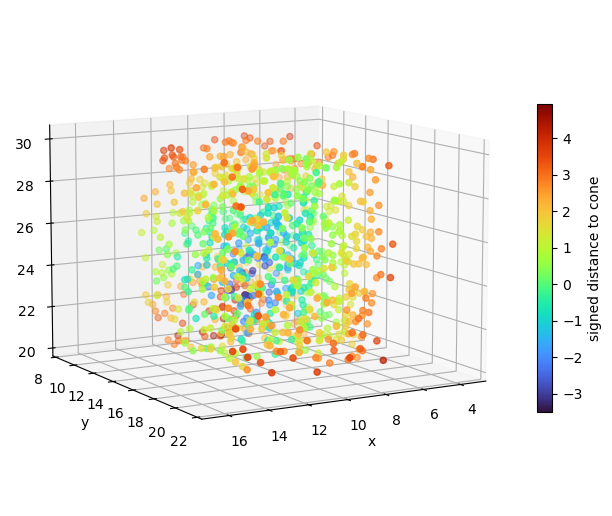

In [12]:
def dist_to_cone(points, apex, normal, half_angle, length=None):

    # Distance to axis
    vec_to_apex = points - apex
    dist_to_axis = np.linalg.norm(np.cross(normal, vec_to_apex), axis=1)
    # Projection on axis
    d_z = vec_to_apex @ normal
    # radius at z
    r_z = np.abs(d_z) * np.tan(half_angle)

    # For a semi-infinite cone there 2 cases to consider:
    d_t = np.zeros(len(points), dtype=float)
    
    # 1. points that are "inside" the cone on z direction
    # (distance to lateral surface)
    inds_in = np.nonzero(d_z < 0)[0]
    d_r = (dist_to_axis - r_z) * np.cos(half_angle)
    d_t[inds_in] = d_r[inds_in]

    # 2. points that are "outside" the cone on z direction
    # (distance to apex)
    inds_out_1 = np.nonzero(d_z >= 0)[0]
    d_t[inds_out_1] = np.linalg.norm(points[inds_out_1] - apex, axis=1)

    # and one more case to consider for a finite cone
    # 3. points that are "outside" the cone on -z direction
    # (distance to circle)
    if length is not None:
        inds_out_2 = np.nonzero(d_z <= -length)[0]
        # Circle size
        r_base = length * np.tan(half_angle)
        c_base = apex - length * normal
        # Distance to end-circle
        vec_to_c_2 = points[inds_out_2] - c_base
        dist_to_axis_2 = np.linalg.norm(np.cross(normal, vec_to_c_2), axis=1)
        dist_to_circle_2 = np.sqrt((vec_to_c_2 @ normal)**2 + (dist_to_axis_2 - r_base)**2)
        d_t[inds_out_2] = dist_to_circle_2

    return d_t

# Generate a set of random points and compute distances to the cone
random_points = np.random.uniform(points_cone.min(axis=0), points_cone.max(axis=0), (1000, 3))
dists_cone = dist_to_cone(random_points, cone_apex, cone_normal, cone_half_angle, cone_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_cone, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to cone')
plt.axis("equal")
plt.show()


### Least squares cone

There is unfortunately no direct method to find the optimal parameters of a cone and resources documenting this problem are again quite scarce.

A solution may be found in: Eberly, D. (1999). Least Squares Fitting of Data by Linear or Quadratic Structures. *Technical report, Geometric Tools*. https://www.geometrictools.com/. 

While very informative, the report focuses on the case of the "positive cone", i.e. the "single-sided" cone verifying $n \cdot (p - c) \geq 0$, only. A slightly different method is proposed here.

By rearranging the the Cartesian equation of the cone:
\begin{equation*}
x^{2} + y^{2} = z^{2}\tan^{2}\alpha
\end{equation*}
it is possible to obtain:
\begin{equation*}
x^{2} + y^{2} + z^{2} - z^{2}(1 + \tan^{2}\alpha) = 0
\end{equation*}

Again, let $u$ and $v$ be unit vectors such as $\{u, v, n\}$ ($n$ being the unit vector giving the direction of the axis) an othonormal basis. A given point $p$ is written:
\begin{equation*}
p = c + q_0.u + q_1.v + q_2.n
\end{equation*}
where $q$ is a column vector whose rows are $q_0 = u \cdot (p - c)$, $q_1 = v \cdot (p - c)$ and $q_2 = n \cdot (p - c)$.

Reinjecting these terms into the rearranged Cartesian equation, the following distance function $f$ is obtained:
\begin{equation*}
f(c, n, \alpha) = ||p - c||^2 - (1 + \tan^{2}\alpha) [n \cdot (p - c)]^2
\end{equation*}

Hence, the least squares error function is:
\begin{equation*}
E(c, n, u, v) = \sum^{n-1}_{i=0} f(c, n, \alpha)^{2}
\end{equation*}

It involves six parameters: one for $\alpha$, three for $c$, and two for $n$ (unit vector expressed with spherical coordinates).

The optimal parameters, minimizing the error function, may be estimated using minimization techniques for nonlinear least squares, such as the Levenberg-Marquardt algorithm.

In practice, the ```least_squares``` function of the ```scipy.optimize``` package offers tools for solving the aforementioned nonlinear least-squares problem quite effortlessly. It allows the user to only provide the distance function for each point and an inital guess of the parameters of the cone. 



Fitted cone apex is: [10. 20. 30.] , normal is: [0.    0.707 0.707] , half angle is: 0.393
Fitted cylinder residual is: 4.550756952501714e-26


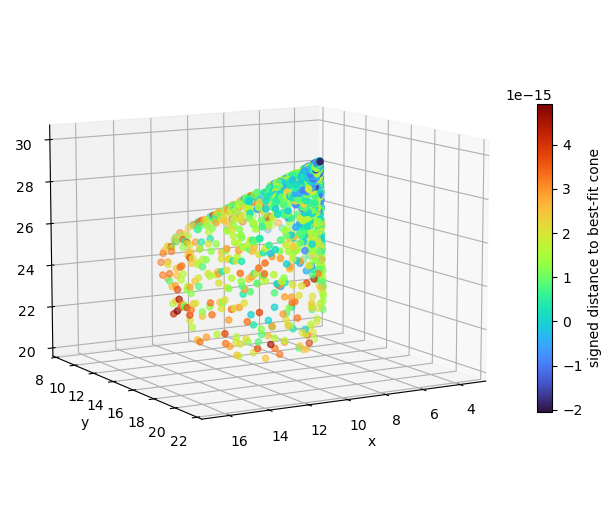

In [13]:
def fit_cone(points, **kwargs):
    """Least squares cone.

    Parameters
    ----------
    points : array_like with shape (n, 3)
        Pointcloud to be fitted.
    center_initial_guess : array_like with shape (3,), optional
        Center initial guess
    normal_initial_guess : array_like with shape (3,), optional
        Normal initial guess
    half_angle_initial_guess : float, optional
        Half angle initial guess
    """

    # Center the pointcloud around its centroid
    centroid = points.mean(axis=0)
    centered_points = points - centroid
    
    # The optimization algorithm needs a starting point or initial_guess
    # (the closer to the cone optimal/real parameters the better)
    initial_guess = np.empty(7)
    # by default center ~ centroid
    initial_guess[:3] = kwargs.get("center_initial_guess", centroid) - centroid # don't forget that points are already centered
    # by default normal ~ direction of bounding box largest dimension
    bbox_size = points.ptp(axis=0)
    normal_default = np.zeros(3)
    normal_default[bbox_size.argmax()] = 1.
    initial_guess[3:6] = kwargs.get("normal_initial_guess", normal_default)
    # radius ~ 45 degrees
    initial_guess[6] = kwargs.get("half_angle_initial_guess", np.pi/4)

    # Optimal parameters are the ones minimizing f
    result = least_squares(
        lambda x : fun(x, centered_points),
        initial_guess,
        method="lm", # Levenberg-Marquardt method
    )
    parameters = result.x
    res = result.cost
    
    # Note : The LM method is described in SciPy documentation as: "the most 
    # efficient method for small unconstrained problems", but it does not 
    # handle bounds, resulting in some parameters having "weird" values (e.g., 
    # negative radius here).
    # It is possible to use another method that handles bounds or simply to 
    # post-process the "problematic" parameters.
    center = parameters[:3] + centroid
    normal = spherical_to_cartesian(parameters[3:5])
    half_angle = parameters[-1]
    
    return (center, normal, half_angle), res

def fun(x, points):
    """Function which computes the vector of residuals. Here the distance to 
    the torus for each point.

    Parameters
    ----------
    x : array_like with shape (5, )
        Parameters of the torus.
    points : array_like with shape (n, 3)
        Pointcloud to be fitted.
    """

    center = x[:3]
    normal = spherical_to_cartesian(x[3:5])
    half_angle = x[-1]

    # squared distances to center
    squared_distance = np.sum((points - center)**2, axis=1)
    # projection on axis
    proj_axis = (points - center) @ normal

    return squared_distance - (1 + np.tan(half_angle)**2) * proj_axis**2
    

# Fit cone to pointcloud
best_fit_cone_parameters, best_fit_cone_res = fit_cone(points_cone)
best_fit_cone_center, best_fit_cone_normal, best_fit_cone_half_angle = best_fit_cone_parameters

with np.printoptions(precision=3, suppress=True):
    print("Fitted cone apex is:", best_fit_cone_center,
          ", normal is:", best_fit_cone_normal,
          ", half angle is: {:.3f}".format(best_fit_cone_half_angle))
print("Fitted cylinder residual is:", best_fit_cone_res)

# Show distance to best-fit
dists_best_fit_cone = dist_to_cone(points_cone, best_fit_cone_center, best_fit_cone_normal, best_fit_cone_half_angle)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points_cone[:, 0], points_cone[:, 1], points_cone[:, 2],
          c=dists_best_fit_cone, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to best-fit cone')
plt.axis("equal")
plt.show()


## Torus

### Torus parameters

It is possible to define a torus whose axis points to z by its Cartesian equation $(\sqrt{(x - c_x)^2 + (y - c_y)^2} - R)^2 + (z - c_z)^2 = r^2$ where $[c_x, c_y, c_z]$ are the coordinates of its center $c$, $R$ its major radius, and $r$ its minor radius.

We consider here a torus of any orientation. The unit vector $n$ designates the direction of the torus axis.


| Parameter | Description |
|:----------|:------------|
| $c$       | center |
| $n$       | unit vector giving the direction of the axis |
| $R$       | major radius |
| $r$       | minor radius |



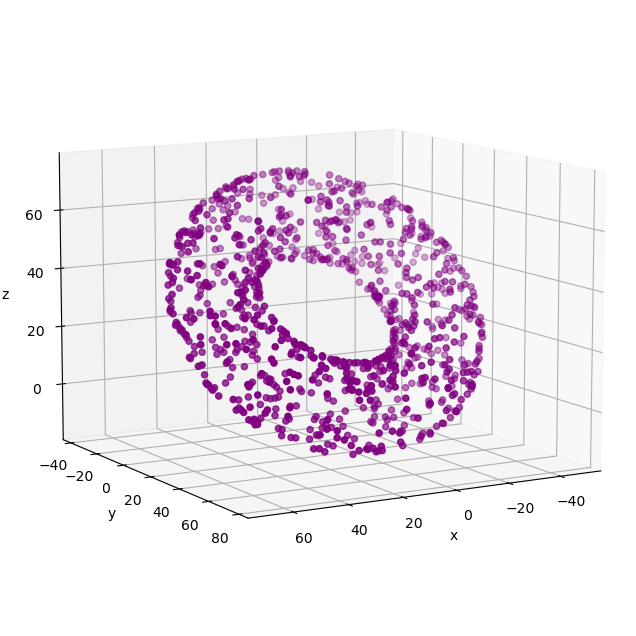

In [14]:
def generate_torus(center, normal, major_radius, minor_radius, n=1000):

    # Start with a torus of custom size pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = (major_radius+ minor_radius * np.cos(theta)) * np.cos(phi)
    y = (major_radius + minor_radius * np.cos(theta)) * np.sin(phi)
    z = minor_radius * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust orientation
    R = rotation_f_to_t(np.array([0., 0., 1.]), normal)
    points = (R @ points.T).T
    # Adjust position
    return points + center

# Generate a torus pointcloud
torus_center = np.array([10., 20., 30.])
torus_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
torus_major_radius = 40
torus_minor_radius = 15.
points_torus = generate_torus(torus_center, torus_normal, torus_major_radius, torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_torus[:, 0], points_torus[:, 1], points_torus[:, 2],
           c="purple")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


### Point-to-torus distance

The signed distance between a point $p$ and a torus $T$ is simply given by:
\begin{equation*}
d(p, T) = \sqrt{[n \cdot (p - c)]^2 + (|| n \times (p - c) || - R)^2} - r
\end{equation*}
the first term being the distance between $p$ and the circle of center $c$ and radius $R$.

Here the positive side corresponds to the "exterior" of the torus.


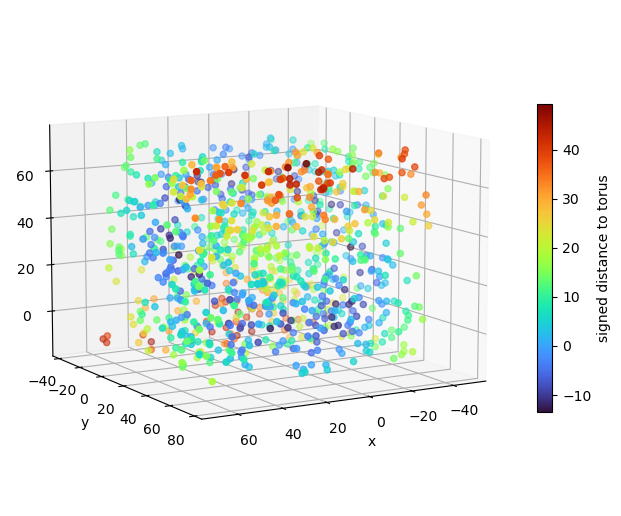

In [15]:
def dist_to_torus(points, center, normal, major_radius, minor_radius):

    vec_to_center = points - center
    # Break the equation in pieces to ensure readability
    s = np.linalg.norm(np.cross(normal, vec_to_center), axis=1)
    t = vec_to_center @ normal

    return np.sqrt(t**2 + (s - major_radius)**2) - minor_radius


# Generate a set of random points and compute distances to the torus
random_points = np.random.uniform(points_torus.min(axis=0), points_torus.max(axis=0), (1000, 3))
dists_torus = dist_to_torus(random_points, torus_center, torus_normal, torus_major_radius, torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_torus, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to torus')
plt.axis("equal")
plt.show()


### Least squares torus

There is unfortunately no direct method to find the optimal parameters of a torus and resources documenting this problem are again quite scarce.

A solution may be found in: Eberly, D. (2018). Fitting 3d data with a torus. Technical report, Geometric Tools. https://www.geometrictools.com/.

By expanding, rearranging and squaring the the Cartesian equation of the torus:
\begin{equation*}
(\sqrt{x^2 + y^2} - R)^2 + z^2 = r^2
\end{equation*}
it is possible to obtain:
\begin{equation*}
(x^2 + y^2 + z^2 + R^2 - r^2)^2 - 4R^{2}(x^2 + y^2) = 0
\end{equation*}

Let $u$ and $v$ be unit vectors such as $\{u, v, n\}$ ($n$ being the unit vector giving the direction of the axis) an othonormal basis. A given point $p$ is written:
\begin{equation*}
p = c + q_0.u + q_1.v + q_2.n
\end{equation*}
where $q$ is a column vector whose rows are $q_0 = u \cdot (p - c)$, $q_1 = v \cdot (p - c)$ and $q_2 = n \cdot (p - c)$.

Reinjecting these terms into the equation, the following squared distance function $F$ is obtained:
\begin{equation*}
F(c, n, R^2, r^2) = (||p - c||^2 + R^2 - r^2)^2 - 4R^2(||p - c||^2 - [n \cdot (p - c)]^2)
\end{equation*}

Defining $u = R^2$ and $v = R^2 - r ^2$ with $r_0 \geq r_1 > 0$, the least squares error function is:
\begin{equation*}
E(c, n, u, v) = \sum^{n-1}_{i=0} F(c, n, R^2, r^2)
\end{equation*}
(note that $F$ is already the squared distance function).

It involves six parameters: one for $r_1$, one for $r_0$, three for $c$, and two for $n$ (unit vector expressed with spherical coordinates).

The optimal parameters, minimizing the error function, may be estimated using minimization techniques for nonlinear least squares, such as the Levenberg-Marquardt algorithm. The cited report also gives an additional method for cases in which the points cover a large portion of the torus.

In practice, the ```least_squares``` function of the ```scipy.optimize``` package offers tools for solving the aforementioned nonlinear least-squares problem quite effortlessly. It allows the user to only provide the distance function for each point and an inital guess of the parameters of the torus. 

The implementation below uses the square root of $F$ (but we could have also used ```dist_to_torus``` directly):
\begin{equation*}
f(c, n, R, r) = ||p - c||^2 + R^2 - r^2 - 2R\sqrt{||p - c||^2 - [n \cdot (p - c)]^2}
\end{equation*}

The torus parameters are here estimated using the pointcloud centroid and bounding box, as these quantities are quite easy to compute, but any other technique may be used instead.


Fitted torus center is: [10. 20. 30.] , normal is: [0.    0.707 0.707] , major radius is: 40.000 , minor radius is: 15.000
Fitted cylinder residual is: 9.155855405196325e-23


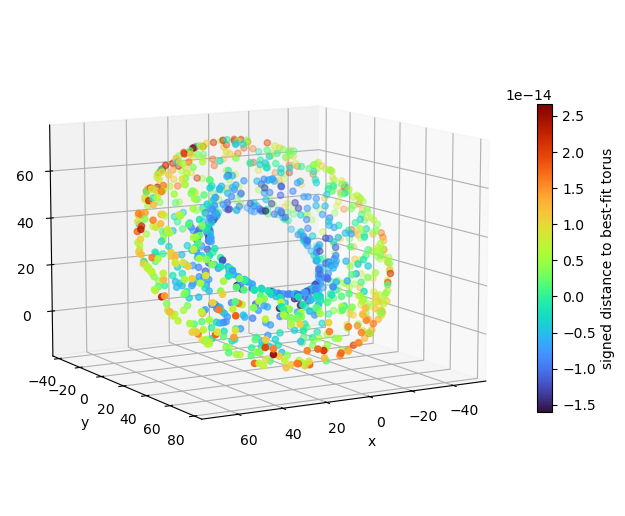

In [16]:
def fit_torus(points, **kwargs):
    """Least squares torus.

    Parameters
    ----------
    points : array_like with shape (n, 3)
        Pointcloud to be fitted.
    center_initial_guess : array_like with shape (3,), optional
        Center initial guess
    normal_initial_guess : array_like with shape (3,), optional
        Normal initial guess
    major_radius_initial_guess : float, optional
        Major radius initial guess
    minor_radius_initial_guess : float, optional
        Minor radius initial guess
    """

    # Center the pointcloud around its centroid
    centroid = points.mean(axis=0)
    centered_points = points - centroid
    
    # The optimization algorithm needs a starting point or initial_guess
    # (the closer to the torus optimal/real parameters the better)
    initial_guess = np.empty(8)
    # by default center ~ centroid
    initial_guess[:3] = kwargs.get("center_initial_guess", centroid) - centroid # don't forget that points are already centered
    # by default normal ~ direction of bounding box smallest dimension
    bbox_size = points.ptp(axis=0)
    normal_default = np.zeros(3)
    normal_default[bbox_size.argmin()] = 1.
    initial_guess[3:6] = kwargs.get("normal_initial_guess", normal_default)
    # radius ~ half of bounding box largest dimensions
    _, minor_radius_default, major_radius_default = np.sort(bbox_size)/2
    initial_guess[6] = kwargs.get("major_radius_initial_guess", major_radius_default)
    initial_guess[7] = kwargs.get("minor_radius_initial_guess", minor_radius_default)

    # Optimal parameters are the ones minimizing f
    result = least_squares(
        lambda x : fun(x, centered_points),
        initial_guess,
        method="lm", # Levenberg-Marquardt method
    )
    parameters = result.x
    res = result.cost
    
    # Note : The LM method is described in SciPy documentation as: "the most 
    # efficient method for small unconstrained problems", but it does not 
    # handle bounds, resulting in some parameters having "weird" values (e.g., 
    # negative radius here).
    # It is possible to use another method that handles bounds or simply to 
    # post-process the "problematic" parameters.
    center = parameters[:3] + centroid
    normal = spherical_to_cartesian(parameters[3:5])
    major_radius = np.abs(parameters[-2])
    minor_radius = np.abs(parameters[-1])
    
    return (center, normal, major_radius, minor_radius), res

def fun(x, points):
    """Function which computes the vector of residuals. Here the distance to 
    the torus for each point.

    Parameters
    ----------
    x : array_like with shape (7, )
        Parameters of the torus.
    points : array_like with shape (n, 3)
        Pointcloud to be fitted.
    """

    center = x[:3]
    normal = spherical_to_cartesian(x[3:5])
    major_radius = x[-2]
    minor_radius = x[-1]

    # squared distances to center
    squared_distance = np.sum((points - center)**2, axis=1)
    # projection on axis
    proj_axis = (points - center) @ normal

    return squared_distance + major_radius**2 - minor_radius**2 - 2 * major_radius * np.sqrt(squared_distance - proj_axis**2)
    

# Fit torus to pointcloud
best_fit_torus_parameters, best_fit_torus_res = fit_torus(points_torus)
best_fit_torus_center, best_fit_torus_normal, best_fit_torus_major_radius, best_fit_torus_minor_radius = best_fit_torus_parameters

with np.printoptions(precision=3, suppress=True):
    print("Fitted torus center is:", best_fit_torus_center,
          ", normal is:", best_fit_torus_normal,
          ", major radius is: {:.3f}".format(best_fit_torus_major_radius),
          ", minor radius is: {:.3f}".format(best_fit_torus_minor_radius))
    
print("Fitted cylinder residual is:", best_fit_torus_res)


# Show distance to best-fit
dists_best_fit_torus = dist_to_torus(points_torus, best_fit_torus_center, best_fit_torus_normal, best_fit_torus_major_radius, best_fit_torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points_torus[:, 0], points_torus[:, 1], points_torus[:, 2],
          c=dists_best_fit_torus, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('signed distance to best-fit torus')
plt.axis("equal")
plt.show()


## Wrapping up

You should now have a better grasp of what are geometric primitives (planes, spheres, cylinders, cones, and tori), what are their possible parameters, and how to fit them to a set of 3D points.

The least squares method has been considered here for finding the optimal parameters for each surface. It is classically used in many fields due to its conceptual simplicity, its optimality from a statistical point of view and its ease of numerical resolution. However, note that the results are sensitive to the presence of noise or outliers (pointclouds are supposed to have been perfectly segmented here). Other methods, such as the least median of squares, are preferable when the latter constitute a non-negligible part of the data.

Beyond the mathematical formulation of this problem, a key takeaway is that pointclouds are often (even partially) transformed into "higher-level" representations in order to enable more efficient storage and manipulation of 3D shapes. These often include geometric primitives, as their simplicity and ubiquity make them some of the preferred parametric surface types for the pointcloud abstraction process. 

Replacing points by primitive patches is usually seen as one of the first steps of this abstraction process, but it is totally possible to go further by deducing spatial relationships among primitives (proximity, intersection, perpendicularity, etc.). This is for example the case for the reverse engineering process, which attempts to reconstruct a CAD model from a pointcloud. This CAD model is usually a boundary representation or B-Rep, which roughly represents a solid as a set of connected surfaces. These are often geometric primitives, but other surfaces such as freeform surfaces are also quite common (one way to represent them consists in using Non-uniform rational basis spline or NURBS). But this is another story!
